In [1]:
from google.colab import drive
import kagglehub
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

import torchaudio


from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal= plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle=cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


# Importation des données:

---


**Speech accent archive:**
* Speech accent archive a été créée pour présenter uniformément un grand ensemble d'accents de discours provenant de divers parcours linguistiques. Des locuteurs natifs et non natifs de l'anglais lisent tous le même paragraphe en anglais et sont soigneusement enregistrés.
* Ce jeu de données contient deux fichier un qui contient les fichiers audios(mp3) et un fichier texte qui contient la paragraphe en anglais.

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rtatman/speech-accent-archive")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/speech-accent-archive


In [ ]:
destination = '/content/drive/MyDrive/English-accent-dataset'

# Copier les fichiers dans Google Drive
shutil.copytree(path, destination)

print(f"Dataset copié dans : {destination}")


Dataset copié dans : /content/drive/MyDrive/English-accent-dataset


# **Termes clés concernant les fichiers audio :**


---


# Fréquence:
* La fréquence d’un audio correspond au
nombre de vibrations (oscillations) d’une onde sonore par seconde.
* 20 – 250 Hz	Basses (sons graves)

* 250 – 2000 Hz	Médiums (paroles humaines)

* 2000 – 20000 Hz	Aigus (sons perçants)
* L’oreille humaine entend en général de 20 Hz à 20 000 Hz.
* 1000 Hz (1 kHz) = 1000 vibrations par seconde.

# Intensité (db/ power):
* L’intensité (ou amplitude) d’un audio mesure combien d’énergie transporte l’onde sonore.

* Elle est liée à la hauteur des vagues de l’onde sonore.
* Plus l’onde est « haute », plus le son est fort.
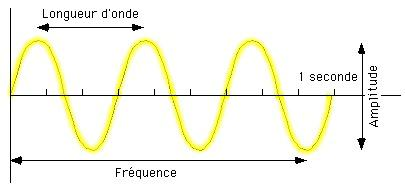
# Sampling rate:
* Le sampling rate (ou fréquence d’échantillonnage) est le nombre d’échantillons que l’on prend par seconde pour représenter un son analogique sous forme numérique.
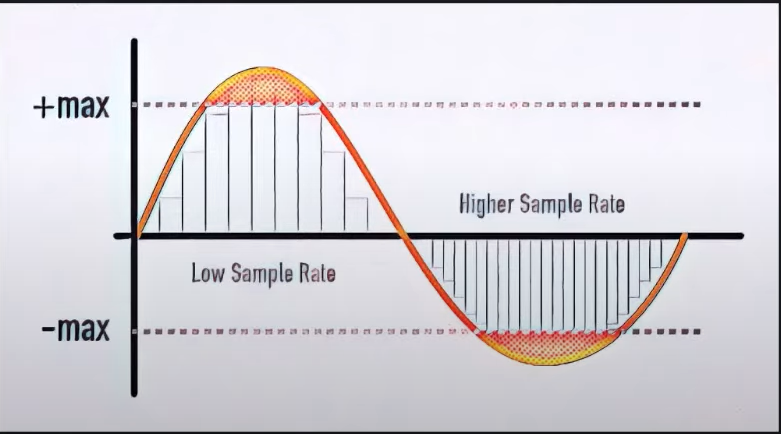

# **Lecture des fichiers audio:**

---


* Il existe plusieurs formats de fichiers audio couramment utilisés, tels que mp3, wav, m4a, flac ou ogg.
* Dans notre dataset, les fichiers audio sont au format .mp3.

In [3]:
audio_files = glob('/content/drive/MyDrive/English-accent-dataset/recordings/recordings/*.mp3')

In [19]:
ipd.Audio(audio_files[23])

# **Prétraitement des données audio :**

---



In [7]:
y, sr= librosa.load(audio_files[0]) # y est un array qui contient les amplitudes du fichier audio
print(f'y :{y[:10]}')
print(f'sr : {sr}')

y :[ 0.00323694 -0.00356178 -0.00168397  0.00269967 -0.00282407  0.00654717
  0.00021672  0.00351303 -0.00146281  0.00273623]
sr : 22050


In [8]:
pd.Series(y)

0         0.003237
1        -0.003562
2        -0.001684
3         0.002700
4        -0.002824
            ...   
492519   -0.000015
492520   -0.001528
492521   -0.000951
492522   -0.004807
492523   -0.008012
Length: 492524, dtype: float32

<Axes: >

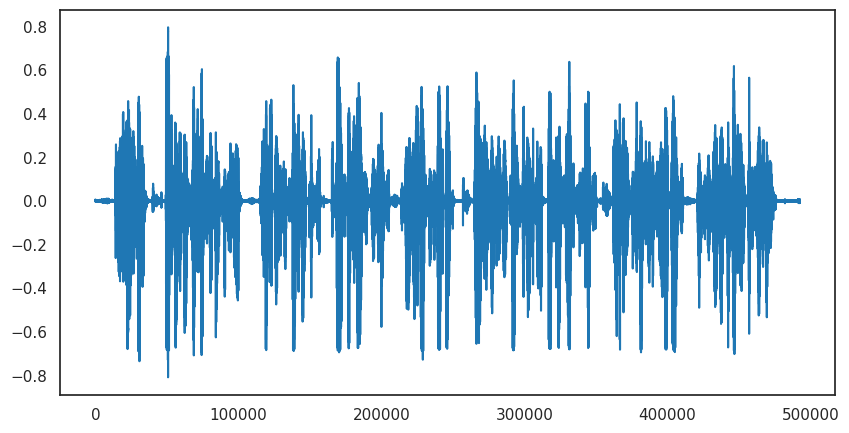

In [9]:
pd.Series(y).plot(figsize=(10,5))

In [10]:
y_trimmed,_=librosa.effects.trim(y, top_db=5)
y_trimmed

array([0.01013541, 0.02473876, 0.04247479, ..., 0.01330926, 0.0154721 ,
       0.01479802], dtype=float32)

<Axes: >

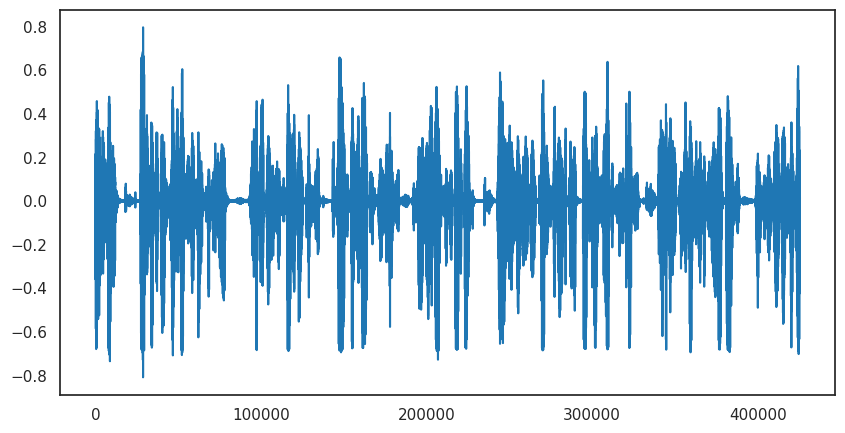

In [11]:
pd.Series(y_trimmed).plot(figsize=(10,5))

<Axes: title={'center': 'zoomed in'}>

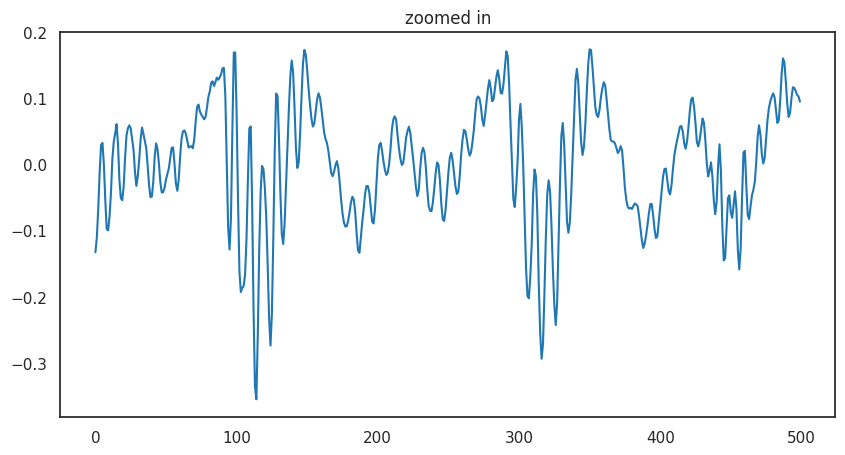

In [12]:
pd.Series(y[200000:200500]).plot(figsize=(10,5),
                                 title="zoomed in")

# Spectrogramme:
* C'est une representation visuellle de l'intensité des fréquences en fonction du temps
* C'est une transformation 2D (fréquence en fonction du temps) d'un signal audio 1D (temps)
* La couleurs dans la carte représentative du spectrogramme représente l'intensité du fréquence a cet instant (souvent en dB)
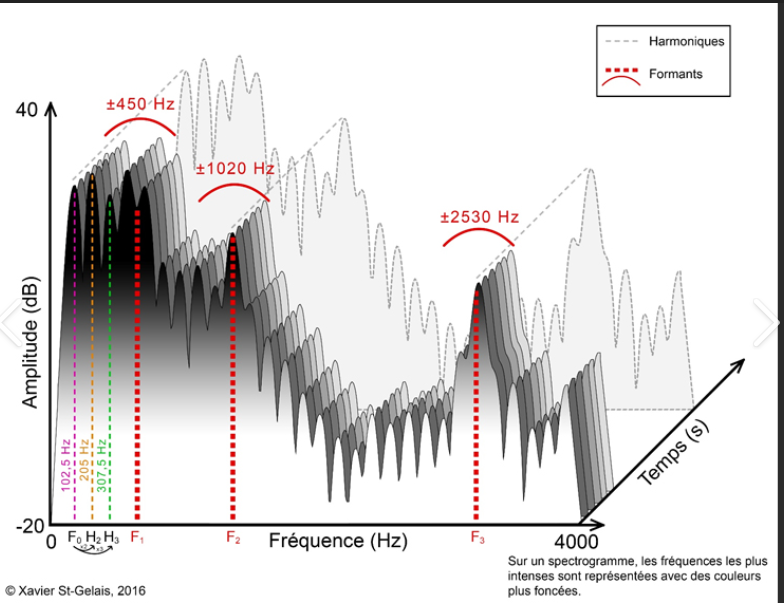
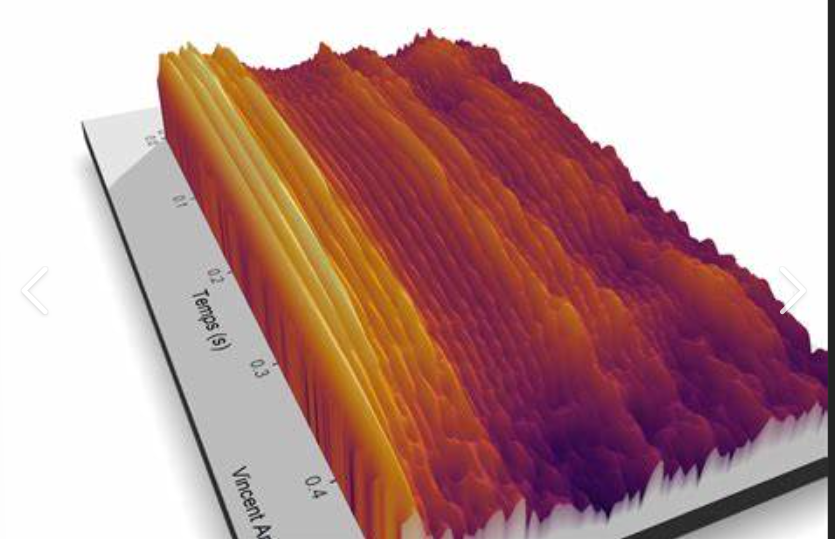
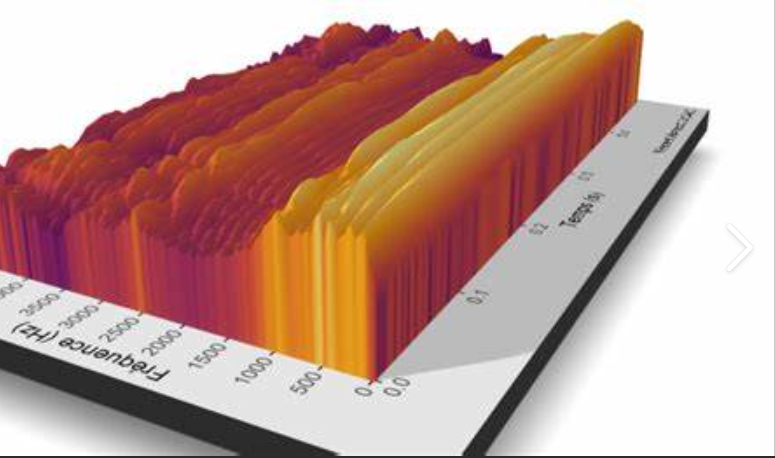
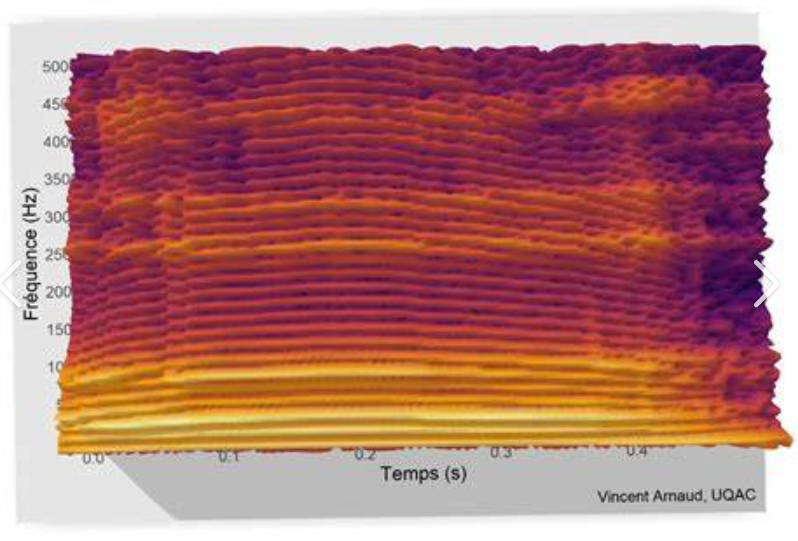

# Le spectrogramme est obtenu grâce à la STFT (Short-Time Fourier Transform) :

* On découpe le signal audio en petites fenêtres (par exemple 25 ms).

* On applique la transformation de Fourier sur chaque fenêtre pour obtenir les fréquences présentes.

* On répète pour tout le signal, ce qui donne une carte temps-fréquence.



In [13]:
D=librosa.stft(y)
S_db =librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 962)

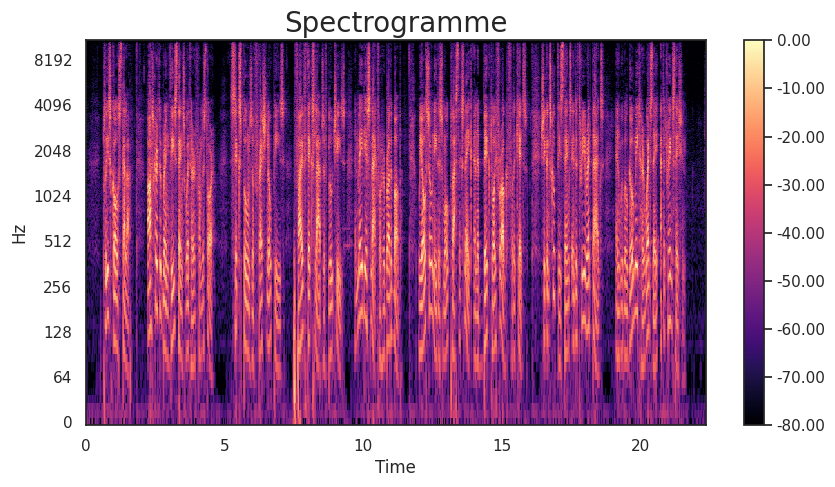

In [14]:
fig, ax= plt.subplots(figsize=(10,5))
img=librosa.display.specshow(S_db,
                             x_axis='time',
                             y_axis='log',
                             ax=ax)
ax.set_title('Spectrogramme', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# Mel spectrogramme (melodic spectrogram):
* L’échelle Mel transforme les fréquences (Hz) en valeurs plus proches de la perception humaine.

Grave : détaillé (plus de résolution), basses fréquences (20 Hz – 500 Hz) → sons comme un tambour, une voix profonde

Aigu : compressé (moins de résolution), hautes fréquences (2000 Hz – 20 000 Hz) → sons comme un sifflet, la lettre "s"

* Sur une échelle linéaire (spectrogramme normal), toutes les fréquences sont espacées de manière égale, Mais, ce n'est pas comme ça que notre oreille entend.
* L’échelle Mel accorde plus d’attention aux graves, car l’humain y est plus sensible. L'espacement est resserré dans les aigus et étendu dans les graves

* C’est un spectrogramme transformé :

  X : le temps,

  Y : les "mels" (fréquences perçues),

* couleur : intensité des composantes sonores.

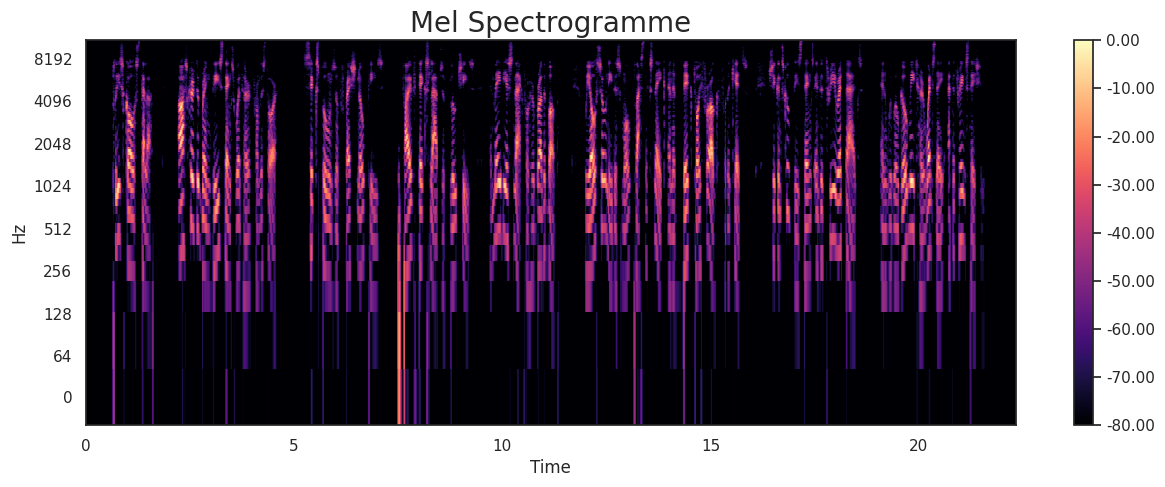

In [15]:
S=librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db_mel =librosa.amplitude_to_db(S, ref=np.max)

fig, ax= plt.subplots(figsize=(15,5))
img=librosa.display.specshow(S_db_mel,
                             x_axis='time',
                             y_axis='log',
                             ax=ax)
ax.set_title('Mel Spectrogramme', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# **Les données texte :**

---



In [4]:
filename= '/content/drive/MyDrive/English-accent-dataset/reading-passage.txt'
with open(filename, 'r') as f:
  lines=f.readlines()
phrase=[]
for line in lines:
  line=line.strip().split()
  line=" ".join(line)
  phrase.append(line)
phrase=phrase[0].replace(',',"").replace('.',"").replace(':',"").replace("'","")
phrase

'Please call Stella Ask her to bring these things with her from the store Six spoons of fresh snow peas five thick slabs of blue cheese and maybe a snack for her brother Bob We also need a small plastic snake and a big toy frog for the kids She can scoop these things into three red bags and we will go meet her Wednesday at the train station'

# **Prétraitement des données audio pour Whisper:**

---



In [5]:
audio_path = audio_files[0]
speech_array, sampling_rate = torchaudio.load(audio_path)

# Resample to 16kHz if needed
if sampling_rate != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
    speech_array = resampler(speech_array)

# Convert to 1D numpy array
import numpy as np
speech = speech_array[0].numpy()

In [6]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

model_name = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_name)
model = WhisperForConditionalGeneration.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

In [7]:
inputs = processor(speech, sampling_rate=16000, return_tensors="pt")

# **Model Whisper (Inference)**

---

**Whisper**
* est un système de reconnaissance automatique de la parole (ASR) open-source développé par OpenAI. C’est un modèle de deep learning entraîné sur un énorme et très diversifié ensemble de données (680000 heures) supervisées multilingues et multitâches.
* Son architecture repose sur les Transformers, une technologie de pointe en traitement du langage et de l’audio.
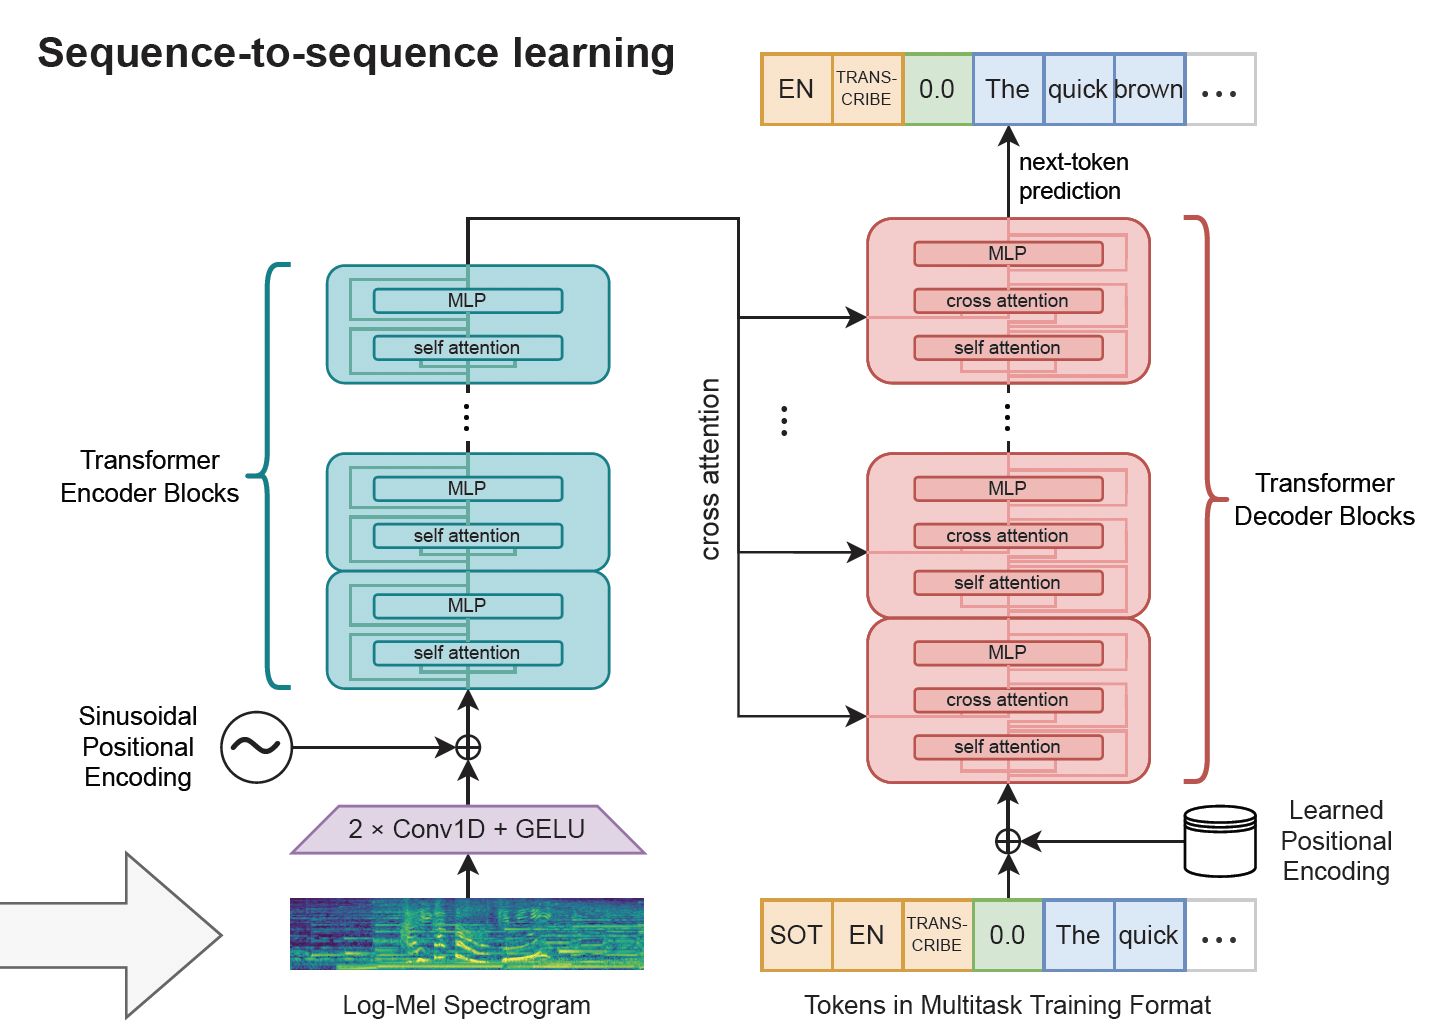

In [8]:
# Generate predicted token IDs
predicted_ids = model.generate(inputs.input_features)

# Decode to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
print("Transcription:", transcription)


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transcription:  Please call Stella. Ask her to bring these things with her from the store. Six spoons of fresh snow peas, five thick slabs of blue cheese and maybe a snack for her brother Bob. We also need a small plastic snake and a big toy frog for the kids. She can scoop these things into three red bags and we will go meet her Wednesday at the train station.


In [9]:
transcription=transcription.replace(',',"").replace('.',"").replace(':',"").replace("'","").strip()
transcription

'Please call Stella Ask her to bring these things with her from the store Six spoons of fresh snow peas five thick slabs of blue cheese and maybe a snack for her brother Bob We also need a small plastic snake and a big toy frog for the kids She can scoop these things into three red bags and we will go meet her Wednesday at the train station'

# Performance du modele:
l'une des metrics pour l'evaluation d'un modele comme Whisper:
* WER (Word Error Rate): Le WER mesure la différence entre la transcription générée par un modèle (texte prédit) et la transcription correcte (texte de référence), en calculant le nombre minimal d’opérations nécessaires pour transformer le texte prédit en texte de référence.

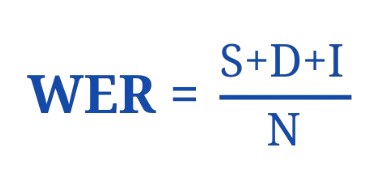

* Substitutions (S) : un mot incorrect remplace un mot correct

* Insertions (I) : un mot supplémentaire non attendu est ajouté

* Suppressions (D) : un mot attendu est manquant

In [11]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.7 MB/s eta 0:00:00


In [12]:
from jiwer import wer
error = wer(phrase,transcription)
print(f"Predicted: {transcription}")
print(f'WER: {error}')

Predicted: Please call Stella Ask her to bring these things with her from the store Six spoons of fresh snow peas five thick slabs of blue cheese and maybe a snack for her brother Bob We also need a small plastic snake and a big toy frog for the kids She can scoop these things into three red bags and we will go meet her Wednesday at the train station
WER: 0.0




---



---


**Interprétation:**
* le résultat est WER = 0, ce qui signifie que la transcription est parfaite et sans aucue erreur.

---



---



* CER (Character Error Rate): mesure le
nombre de caractères erronés (insertion, suppression, substitution) entre le texte de référence et le texte prédit.

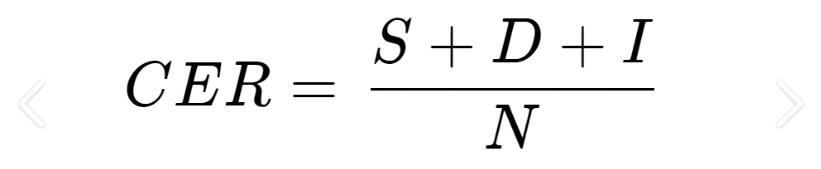

In [13]:
import jiwer
cer = jiwer.cer(transcription,phrase)

print(f"CER: {cer:.2%}")

CER: 0.00%


In [14]:
print(transcription)
print(phrase)

Please call Stella Ask her to bring these things with her from the store Six spoons of fresh snow peas five thick slabs of blue cheese and maybe a snack for her brother Bob We also need a small plastic snake and a big toy frog for the kids She can scoop these things into three red bags and we will go meet her Wednesday at the train station
Please call Stella Ask her to bring these things with her from the store Six spoons of fresh snow peas five thick slabs of blue cheese and maybe a snack for her brother Bob We also need a small plastic snake and a big toy frog for the kids She can scoop these things into three red bags and we will go meet her Wednesday at the train station


In [23]:
wer_scores = []
cer_scores = []
input =[]
for audio_path in audio_files[:210]:
    speech_array, sampling_rate = torchaudio.load(audio_path)
    if sampling_rate != 16000:
      resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
      speech_array = resampler(speech_array)
    speech = speech_array[0].numpy()

    inputs = processor(speech, sampling_rate=16000, return_tensors="pt")
    input.append(inputs)

In [24]:
for inputs in input:

    predicted_ids = model.generate(inputs.input_features)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    print(transcription)
    transcription=transcription.replace(',',"").replace('.',"").replace(':',"").replace("'","").strip()

    error = wer(phrase,transcription)
    wer_scores.append(error)
    cer = jiwer.cer(transcription,phrase)
    cer_scores.append(cer)
print(wer_scores[:10])
print(cer_scores[:10])

 Please call Steller. Ask her to bring these things with her from the store. Six spoons of fresh snow peas. Five thick slabs of blue cheese and maybe a snack for her brother Bob. We also need a small plastic snake and a big toy frog for the kids. She can scoop these things into three red bags and we will go meet her when is at the train station.
 Please call Stella as card to bring these things with her from the store. 6 spoons of fresh milk peas, 5-6 slabs of brooches and maybe a snack for her brother Bob. We also need a small plastic snake and a big toy frog for the kids. She can scoop these things into 3 red bags and we will go meet her Wednesday at the train station.
 Please call Stella, ask her to bring these things with her from the store. Six spoons of fresh snow peas, five chick slabs of blue cheese and maybe a snack for her brother Bob. We also need a small plastic snake and a big toy frog for the kids. She can scoop these things into three red bags and we will go meet her Wed

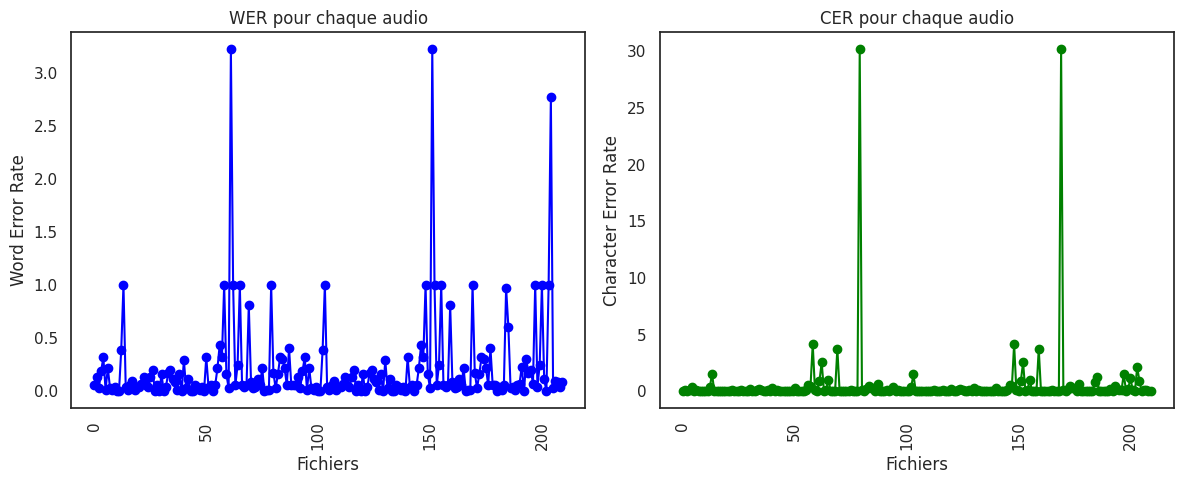

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(wer_scores, marker='o', color='blue')
plt.title("WER pour chaque audio")
plt.xlabel("Fichiers")
plt.ylabel("Word Error Rate")
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.plot(cer_scores, marker='o', color='green')
plt.title("CER pour chaque audio")
plt.xlabel("Fichiers")
plt.ylabel("Character Error Rate")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()



---



---


**Interpretation:**
* WER:

*
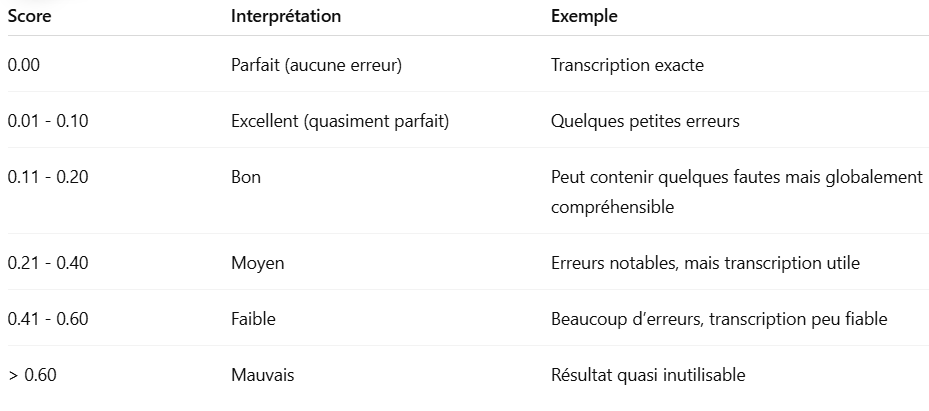

* CER:
  * CER < 10% = excellent
  * CER < 20% = acceptable
  * CER >= 40% = problématique
---
---
